<a href="https://colab.research.google.com/github/amarkanday/experimentation-examples/blob/main/stepped_wedge_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

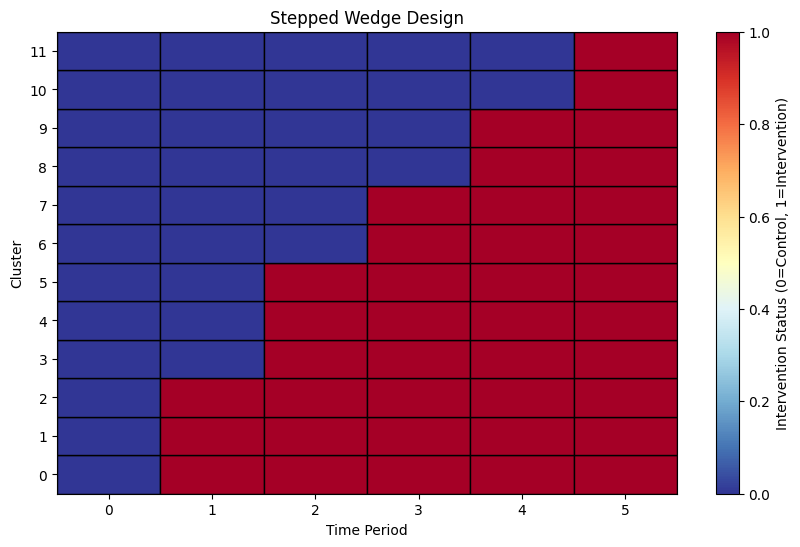

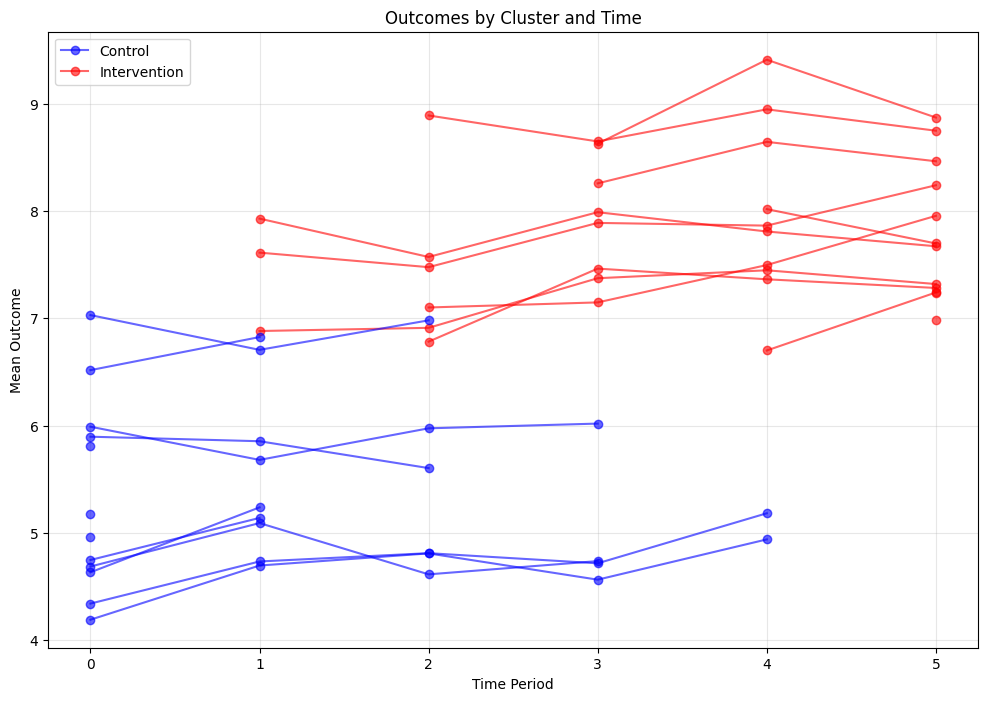

Analysis Results:
Treatment effect estimate: 2.383
95% CI: (1.914, 2.852)
Time effect estimate: 0.021

Conducting power analysis...


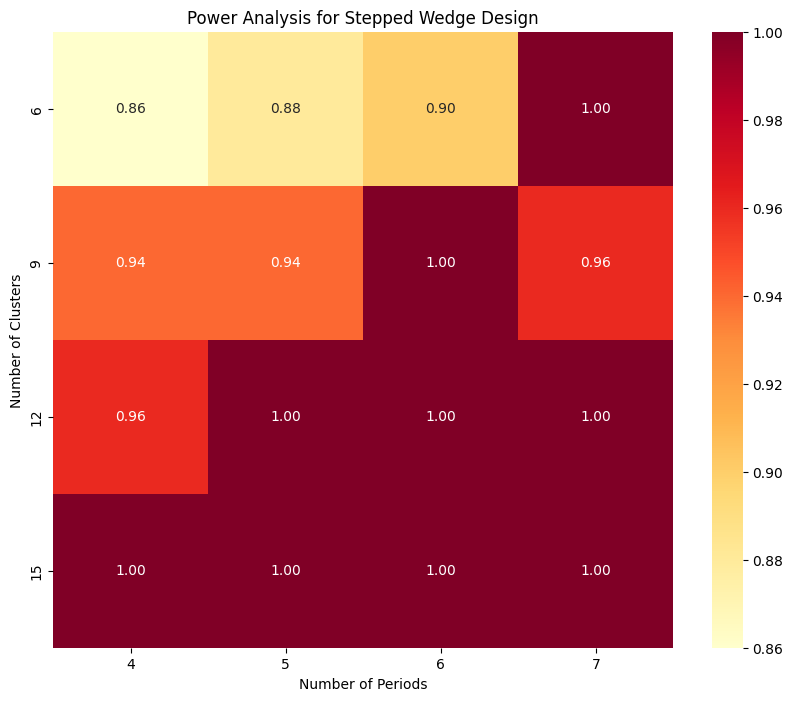

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats

class SteppedWedgeDesign:
    """
    Simulate and analyze a stepped wedge cluster randomized trial
    """
    def __init__(self, n_clusters, n_periods, cluster_size,
                 baseline_mean=5.0, treatment_effect=2.0,
                 cluster_variance=1.0, individual_variance=2.0,
                 time_effect=0.1):
        """
        Initialize stepped wedge design parameters

        Parameters:
        -----------
        n_clusters : int
            Number of clusters
        n_periods : int
            Number of time periods
        cluster_size : int or list
            Size of each cluster (can be uniform or varying)
        baseline_mean : float
            Baseline outcome value
        treatment_effect : float
            Effect of intervention
        cluster_variance : float
            Between-cluster variance
        individual_variance : float
            Within-cluster variance
        time_effect : float
            Secular trend (change over time)
        """
        self.n_clusters = n_clusters
        self.n_periods = n_periods

        # Handle cluster sizes
        if isinstance(cluster_size, int):
            self.cluster_sizes = [cluster_size] * n_clusters
        else:
            self.cluster_sizes = cluster_size

        self.baseline_mean = baseline_mean
        self.treatment_effect = treatment_effect
        self.cluster_variance = cluster_variance
        self.individual_variance = individual_variance
        self.time_effect = time_effect

        # Create design matrix
        self.design_matrix = self.create_design_matrix()

    def create_design_matrix(self):
        """Create the stepped wedge design matrix"""
        n_steps = self.n_periods - 1
        clusters_per_step = self.n_clusters // n_steps
        remainder = self.n_clusters % n_steps

        design = np.zeros((self.n_clusters, self.n_periods))

        current_cluster = 0
        for step in range(n_steps):
            clusters_in_this_step = clusters_per_step + (1 if step < remainder else 0)

            for c in range(current_cluster, current_cluster + clusters_in_this_step):
                design[c, step+1:] = 1

            current_cluster += clusters_in_this_step

        return design

    def simulate_data(self, seed=None):
        """Simulate data for the stepped wedge trial"""
        if seed is not None:
            np.random.seed(seed)

        # Generate cluster effects
        cluster_effects = np.random.normal(0, np.sqrt(self.cluster_variance),
                                         self.n_clusters)

        data = []

        for cluster in range(self.n_clusters):
            for period in range(self.n_periods):
                is_treated = self.design_matrix[cluster, period] == 1

                # Calculate mean for this cluster-period
                mean = (self.baseline_mean +
                        cluster_effects[cluster] +
                        self.time_effect * period +
                        (self.treatment_effect if is_treated else 0))

                # Generate individual outcomes
                n_individuals = self.cluster_sizes[cluster]
                individual_outcomes = np.random.normal(
                    mean, np.sqrt(self.individual_variance), n_individuals)

                # Store data
                for i, outcome in enumerate(individual_outcomes):
                    data.append({
                        'cluster': cluster,
                        'period': period,
                        'individual': i,
                        'treated': is_treated,
                        'outcome': outcome
                    })

        self.data = pd.DataFrame(data)
        return self.data

    def analyze_data(self):
        """Analyze the simulated data using mixed effects model approach"""
        # Simple fixed effects analysis
        model_data = self.data.groupby(['cluster', 'period']).agg({
            'outcome': 'mean',
            'treated': 'first'
        }).reset_index()

        # Create design matrices for regression
        X = np.column_stack([
            np.ones(len(model_data)),  # Intercept
            model_data['period'],      # Time effect
            model_data['treated']      # Treatment effect
        ])

        # Fit model using OLS as approximation
        y = model_data['outcome']
        beta = np.linalg.lstsq(X, y, rcond=None)[0]

        results = {
            'intercept': beta[0],
            'time_effect': beta[1],
            'treatment_effect': beta[2]
        }

        # Calculate standard errors (simplified)
        residuals = y - X @ beta
        mse = np.sum(residuals**2) / (len(y) - 3)
        var_cov = mse * np.linalg.inv(X.T @ X)
        se = np.sqrt(np.diag(var_cov))

        results['se_treatment'] = se[2]
        results['ci_lower'] = beta[2] - 1.96 * se[2]
        results['ci_upper'] = beta[2] + 1.96 * se[2]

        return results

    def plot_design(self):
        """Visualize the stepped wedge design"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # Create color map
        cmap = plt.cm.RdYlBu_r

        # Plot design matrix
        for c in range(self.n_clusters):
            for p in range(self.n_periods):
                color = cmap(self.design_matrix[c, p])
                rect = Rectangle((p, c), 1, 1,
                               facecolor=color, edgecolor='black')
                ax.add_patch(rect)

        ax.set_xlim(0, self.n_periods)
        ax.set_ylim(0, self.n_clusters)
        ax.set_xlabel('Time Period')
        ax.set_ylabel('Cluster')
        ax.set_title('Stepped Wedge Design')

        # Add ticks
        ax.set_xticks(np.arange(0.5, self.n_periods, 1))
        ax.set_xticklabels(range(self.n_periods))
        ax.set_yticks(np.arange(0.5, self.n_clusters, 1))
        ax.set_yticklabels(range(self.n_clusters))

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Intervention Status (0=Control, 1=Intervention)')

        return fig, ax

    def plot_outcomes(self):
        """Plot outcomes by cluster and time"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

        # Calculate mean outcomes for each cluster-period
        mean_outcomes = self.data.groupby(['cluster', 'period'])['outcome'].mean().reset_index()

        for cluster in range(self.n_clusters):
            cluster_data = mean_outcomes[mean_outcomes['cluster'] == cluster]

            # Plot control periods
            control_data = cluster_data[~self.design_matrix[cluster].astype(bool)]
            ax.plot(control_data['period'], control_data['outcome'],
                   'o-', color='blue', alpha=0.6)

            # Plot intervention periods
            intervention_data = cluster_data[self.design_matrix[cluster].astype(bool)]
            ax.plot(intervention_data['period'], intervention_data['outcome'],
                   'o-', color='red', alpha=0.6)

        ax.set_xlabel('Time Period')
        ax.set_ylabel('Mean Outcome')
        ax.set_title('Outcomes by Cluster and Time')
        ax.legend(['Control', 'Intervention'])
        ax.grid(True, alpha=0.3)

        return fig, ax

def power_analysis(n_clusters_list, n_periods_list, cluster_size=30,
                   treatment_effect=2.0, n_simulations=100):
    """
    Conduct power analysis for stepped wedge designs
    """
    results = []

    for n_clusters in n_clusters_list:
        for n_periods in n_periods_list:
            significant_count = 0

            for _ in range(n_simulations):
                # Create and simulate design
                swd = SteppedWedgeDesign(n_clusters, n_periods, cluster_size,
                                        treatment_effect=treatment_effect)
                swd.simulate_data()

                # Analyze data
                analysis_results = swd.analyze_data()

                # Check if significant
                if (analysis_results['ci_lower'] > 0 or
                    analysis_results['ci_upper'] < 0):
                    significant_count += 1

            power = significant_count / n_simulations
            results.append({
                'n_clusters': n_clusters,
                'n_periods': n_periods,
                'power': power
            })

    return pd.DataFrame(results)

# Example usage
if __name__ == "__main__":
    # Create and visualize a stepped wedge design
    swd = SteppedWedgeDesign(n_clusters=12, n_periods=6, cluster_size=30)

    # Plot design
    fig1, ax1 = swd.plot_design()
    plt.show()

    # Simulate data
    data = swd.simulate_data(seed=42)

    # Plot outcomes
    fig2, ax2 = swd.plot_outcomes()
    plt.show()

    # Analyze data
    results = swd.analyze_data()
    print("Analysis Results:")
    print(f"Treatment effect estimate: {results['treatment_effect']:.3f}")
    print(f"95% CI: ({results['ci_lower']:.3f}, {results['ci_upper']:.3f})")
    print(f"Time effect estimate: {results['time_effect']:.3f}")

    # Power analysis
    print("\nConducting power analysis...")
    power_results = power_analysis(
        n_clusters_list=[6, 9, 12, 15],
        n_periods_list=[4, 5, 6, 7],
        n_simulations=50  # Increase for more accurate results
    )

    # Plot power analysis results
    pivot_power = power_results.pivot(index='n_clusters',
                                     columns='n_periods',
                                     values='power')

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_power, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Power Analysis for Stepped Wedge Design')
    plt.xlabel('Number of Periods')
    plt.ylabel('Number of Clusters')
    plt.show()